<a href="https://colab.research.google.com/github/praveenkumarbalakrishnan/tasks/blob/main/SIG742Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student ID: 223029369

Student Name: PraveenKumar Balakrishnan

Attempted High Distinction Question: Yes


# Part 1

In [145]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
#update local version of the package catalog
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.1.3
!wget -q http://apache.osuosl.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
# unzip it
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
# install findspark 
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ["SPARK_HOME"] = '/content/spark-3.1.3-bin-hadoop3.2'

import findspark
findspark.init() 

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 3s (83.2 kB/s)
Reading package l

In [106]:
import json
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlxtend.frequent_patterns import (apriori, association_rules,
                                       fpmax, fpgrowth)
from sklearn.neighbors import NearestNeighbors

from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql.window import Window

from google.colab import drive

In [107]:
warnings.filterwarnings('ignore')

In [108]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
def convert_json_to_pandas(filename):
  """
  This function is to read the json files and generate pandas dataframe. It will
  skip the lines in the json data if there is any error in the line and print 
  the same for reference

  Parameters
  ----------
  filename : str
    Absolute path of the json file

  Returns
  -------
  df : pd.DataFrame
    Pandas Dataframe from json data
  """
  full_json_data = []
  with open(filename) as data:
    for line in data:
      try:
        json_data = json.loads(line)
        full_json_data.append(line)
      except ValueError as e:
        print("Error line:", line)
    json_data_str = "[" + ','.join(full_json_data) + "]"
    df = pd.read_json(json_data_str)
    return df
      

In [110]:
df = convert_json_to_pandas('/content/drive/My Drive/Data/assignment2data.json')
df = df.drop_duplicates()

## Answer 1.3

In [111]:
def column_list(df):
  """
  This function is to get the numerical columns and categorical columns from the
  given pandas dataframe

  Parameters
  ----------
  df : pd.DataFrame
    Input dataframe

  Returns
  -------
  numerical_cols : list
    Numerical columns list
  categorical_cols: list
    Categorical columns list
  """
  numerical_cols = []
  categorical_cols = []
  for col, data_type in zip(df.columns, df.dtypes):
    if data_type == 'object':
      categorical_cols.append(col)
    else:
      numerical_cols.append(col)
  return numerical_cols, categorical_cols

In [112]:
numerical_cols, categorical_cols = column_list(df)
print('Numerical columns list:', numerical_cols)
print('Categorical columns list:', categorical_cols)

Numerical columns list: ['sacc_items', 'work_orders', 'female_items', 'male_items', 'afterpay_payments', 'msite_orders', 'wftw_items', 'mapp_items', 'orders', 'cc_payments', 'curvy_items', 'paypal_payments', 'macc_items', 'cancels', 'revenue', 'returns', 'other_collection_orders', 'parcelpoint_orders', 'android_orders', 'days_since_last_order', 'vouchers', 'average_discount_used', 'shipping_addresses', 'redpen_discount_used', 'mftw_items', 'days_since_first_order', 'unisex_items', 'home_orders', 'coupon_discount_applied', 'desktop_orders', 'ios_orders', 'apple_payments', 'wspt_items', 'wacc_items', 'items', 'mspt_items', 'devices', 'different_addresses', 'wapp_items', 'other_device_orders', 'average_discount_onoffer']
Categorical columns list: ['is_newsletter_subscriber', 'customer_id']


In [113]:
# To get the stats on numerical columns
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
sacc_items,46030.0,0.087899,0.539604,0.0,0.0000,0.0000,0.00000,29.00
work_orders,46030.0,0.240995,1.565071,0.0,0.0000,0.0000,0.00000,84.00
female_items,46030.0,6.472800,17.830007,0.0,0.0000,2.0000,5.00000,537.00
male_items,46030.0,1.720660,5.468827,0.0,0.0000,0.0000,1.00000,273.00
afterpay_payments,46030.0,0.053595,0.225220,0.0,0.0000,0.0000,0.00000,1.00
msite_orders,46030.0,0.978557,2.859161,0.0,0.0000,0.0000,1.00000,172.00
wftw_items,46030.0,1.633826,4.088452,0.0,0.0000,0.0000,2.00000,261.00
mapp_items,46030.0,0.926613,3.689578,0.0,0.0000,0.0000,0.00000,151.00
orders,46030.0,4.111362,8.122569,1.0,1.0000,2.0000,4.00000,665.00
cc_payments,46030.0,0.642972,0.479128,0.0,0.0000,1.0000,1.00000,1.00


## Answer 1.4

In [114]:
# To check whether the datatype matches with the meaning of the data
# All are matching
df.dtypes

sacc_items                    int64
work_orders                   int64
female_items                  int64
is_newsletter_subscriber     object
male_items                    int64
afterpay_payments             int64
msite_orders                  int64
wftw_items                    int64
mapp_items                    int64
orders                        int64
cc_payments                   int64
curvy_items                   int64
paypal_payments               int64
macc_items                    int64
cancels                       int64
revenue                     float64
returns                       int64
other_collection_orders       int64
parcelpoint_orders            int64
customer_id                  object
android_orders                int64
days_since_last_order         int64
vouchers                      int64
average_discount_used       float64
shipping_addresses            int64
redpen_discount_used        float64
mftw_items                    int64
days_since_first_order      

In [115]:
# Explored on the stats of the data to find any mismatch data
# Observed sparsity and skewness in the data for lot of columns
df_stats = df.describe().T.reset_index().rename(columns={'index': 'column'})
df_stats

,column,count,mean,std,min,25%,50%,75%,max
0,sacc_items,46030.0,0.087899,0.539604,0.0,0.0000,0.0000,0.00000,29.00
1,work_orders,46030.0,0.240995,1.565071,0.0,0.0000,0.0000,0.00000,84.00
2,female_items,46030.0,6.472800,17.830007,0.0,0.0000,2.0000,5.00000,537.00
3,male_items,46030.0,1.720660,5.468827,0.0,0.0000,0.0000,1.00000,273.00
4,afterpay_payments,46030.0,0.053595,0.225220,0.0,0.0000,0.0000,0.00000,1.00
5,msite_orders,46030.0,0.978557,2.859161,0.0,0.0000,0.0000,1.00000,172.00
6,wftw_items,46030.0,1.633826,4.088452,0.0,0.0000,0.0000,2.00000,261.00
7,mapp_items,46030.0,0.926613,3.689578,0.0,0.0000,0.0000,0.00000,151.00
8,orders,46030.0,4.111362,8.122569,1.0,1.0000,2.0000,4.00000,665.00
9,cc_payments,46030.0,0.642972,0.479128,0.0,0.0000,1.0000,1.00000,1.00


In [116]:
# To find columns with sparsity
df_stats[(df_stats['min'] == df_stats['75%']) & (df_stats['min'] == 0)]

,column,count,mean,std,min,25%,50%,75%,max
0,sacc_items,46030.0,0.087899,0.539604,0.0,0.0,0.0,0.0,29.0
1,work_orders,46030.0,0.240995,1.565071,0.0,0.0,0.0,0.0,84.0
4,afterpay_payments,46030.0,0.053595,0.225220,0.0,0.0,0.0,0.0,1.0
7,mapp_items,46030.0,0.926613,3.689578,0.0,0.0,0.0,0.0,151.0
10,curvy_items,46030.0,0.041321,0.782744,0.0,0.0,0.0,0.0,116.0
12,macc_items,46030.0,0.573908,2.542536,0.0,0.0,0.0,0.0,353.0
13,cancels,46030.0,0.053096,2.175601,0.0,0.0,0.0,0.0,460.0
17,parcelpoint_orders,46030.0,0.025418,0.452441,0.0,0.0,0.0,0.0,32.0
18,android_orders,46030.0,0.043167,0.537200,0.0,0.0,0.0,0.0,33.0
24,mftw_items,46030.0,0.421290,1.444193,0.0,0.0,0.0,0.0,78.0


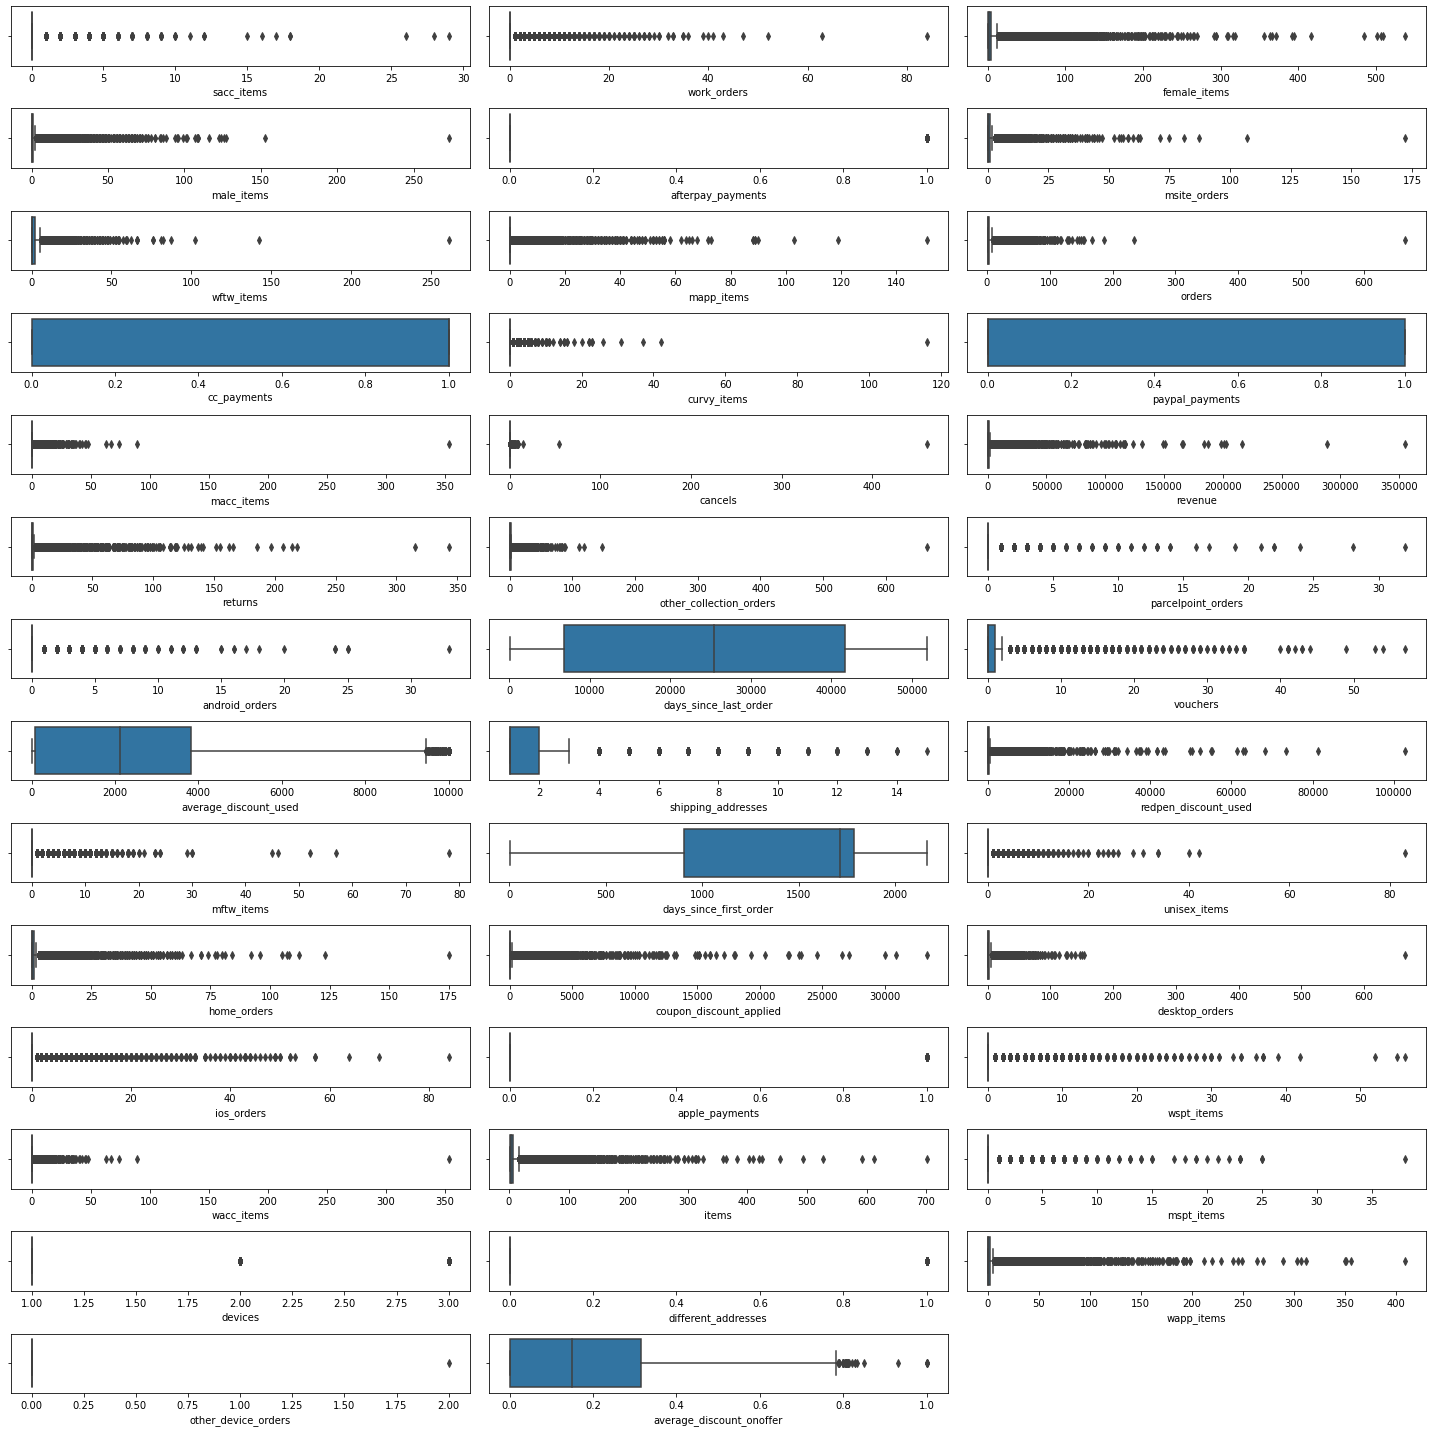

In [117]:
# Plot box plot to check for any extreme values
# Observed skewness in the below columns
# afterpay_payments, apple_payments, different_addresses, devices\
# and other_device_orders
fig = plt.figure(figsize=(20,20))
c = 1
for col in numerical_cols:
    plt.subplot(14, 3, c)
    sns.boxplot(x=col, data=df)
    c = c + 1

plt.tight_layout()
plt.show()

In [118]:
# apple_payments & other_device_orders are extremely sparse
print(df['apple_payments'].value_counts())
print(df['other_device_orders'].value_counts())

0    46004
1       26
Name: apple_payments, dtype: int64
0    46029
2        1
Name: other_device_orders, dtype: int64


In [119]:
# Check the logical definition of the columns
# Sum orders should be equal to the orders
# Collection sum orders should be equal to the orders
df['sum_orders'] = df.apply(lambda x: x['msite_orders'] + x['desktop_orders'] +
                            x['android_orders'] + x['ios_orders'] +
                            x['other_device_orders'], axis=1)
print("Not matching sum_orders count:",
      df[df['sum_orders'] != df['orders']]['customer_id'].count())

df['collection_sum_orders'] = df.apply(lambda x: x['work_orders'] +
                                    x['home_orders'] + x['parcelpoint_orders'] +
                                    x['other_collection_orders'], axis=1)
print("Not matching collection_sum_orders count:",
      df[df['collection_sum_orders'] != df['orders']]['customer_id'].count())

Not matching sum_orders count: 0
Not matching collection_sum_orders count: 0


In [120]:
# Items count should get matched with items in the data
df['items_count'] = df.apply(lambda x: x['female_items'] +
                             x['male_items'] + x['unisex_items'] , axis=1)
df[(df['items'] != df['items_count'])][['customer_id', 'items', 'items_count']]

,customer_id,items,items_count


In [18]:
# Revenue is dollar spent per person as per the data dictionary
# Revenue seems corrupted because if we have atleast 1 order which is not\ 
# returned or cancelled, it should have revenue associated to that unless\ 
# sold at 100% discount. Some the records there are no discounts\ 
# and still revenue is 0
df[
   (df['revenue'] == 0) & (df['orders'] - (df['cancels'] + df['returns']) > 0)
   ][['orders', 'cancels', 'returns','average_discount_onoffer',
        'average_discount_used', 'revenue']]

,orders,cancels,returns,average_discount_onoffer,average_discount_used,revenue
4,1,0,0,0.0000,0.0000,0.0
62,1,0,0,0.0000,0.0000,0.0
70,1,0,0,0.0000,10000.0000,0.0
79,1,0,0,0.2028,2028.1646,0.0
91,4,0,0,0.0000,4998.8999,0.0
...,...,...,...,...,...,...
46038,2,0,0,0.0000,0.0000,0.0
46066,8,0,0,0.0000,770.8333,0.0
46081,1,0,0,0.1999,1999.4499,0.0
46094,2,0,0,0.0000,0.0000,0.0


In [121]:
# orders should be cancels + returns + not_returned
# orders should be greater than on equal to returns + cancels
# We can only cancel the order after it's placed and\
# returned order cannot be cancelled
# cancels and returns are corrupted based on the below observation

corrupted_data_df = df[df['orders'] < df['returns'] + df['cancels']][
    ['customer_id', 'orders', 'cancels', 'returns']]
print('percentage of corrupted data: {0:.2f}%'.format(
        round(
          corrupted_data_df['customer_id'].count() /df['customer_id'].count(),4
        ) * 100))

percentage of corrupted data: 4.15%


In [122]:
corrupted_data_df[
    corrupted_data_df['orders'] < corrupted_data_df['cancels'] +
    corrupted_data_df['cancels']]

,customer_id,orders,cancels,returns
2183,d74deb75e6ade64cc74c65b08661ff30,1,1,1
4181,78eef961ef465d922f381c6c27f49af0,5,4,3
8724,c6c98904a065185674f114f6d04bc302,1,2,0
17174,257dbbc9483589b3294e2ca11f74a246,1,1,1
19888,e2a692f5b9d6cd91119c9d88340fbf68,1,2,0
25125,c3f63a22523014342d757cc03ce445d0,3,2,5
25611,f258621a4186ce7bea4ab138ad5d100d,1,2,0
25854,f93b55212d076942d9c9809d9f26cff8,1,2,0
30764,07c3eb805ba7045c0a9e0f564c9ee441,12,9,16
31475,16d708dd3172e24c14d8013726f8e234,13,7,7


In [21]:
# Solution to correct the corrupted columns, either we can ignore the records\
# or manipulate the corrupted records based on the below logic
# If cancels > orders then update cancels as orders(all orders are cancelled)
# Then if returns > orders - cancels then update returns as orders - cancels\
# only orders - cancels can be returned
df['cancels'] = np.where(
    df['cancels'] > df['orders'], df['orders'], df['cancels'])
df['returns'] = np.where(
    df['returns'] > df['orders'] - df['cancels'], df['orders'] - df['cancels'], df['returns'])
print('No of orders less than cancels + returns: ',
      df[df['orders'] < df['cancels'] + df['returns']]['customer_id'].count())

No of orders less than cancels + returns:  0


In [22]:
# Solution to correct the revenue is, drop the records or\
# if we have the actual_price of the items in the order we can calculate\  
# revenue from that using actual_price - discounts and use that as revenue

## Answer 1.5

In [123]:
# pi - purchased item, cc - credit card
def get_female_pi_percentage_by_cc(df):
  """
  This function is get the percentage of customer who purchased items
  have paid by credit card

  Parameters
  ----------
  df : pd.DataFrame
    Input dataframe

  Returns
  -------
  female_pi_cc_customer_ratio : str
    Percentage of customer purchased items have paid by credit card
  """
  female_pi_customer_cnt = df[df['female_items'] > 0][
      'customer_id'].drop_duplicates().count()
  female_pi_cc_customer_cnt = df[
      (df['female_items'] > 0) & (df['cc_payments'] > 0)][
          'customer_id'].drop_duplicates().count()
  female_pi_cc_customer_ratio = "{0:.2f}%".format(
      (female_pi_cc_customer_cnt / female_pi_customer_cnt) * 100)
  return female_pi_cc_customer_ratio

In [124]:
print('Percentage of customers purchased female items have paid by credit card',
      get_female_pi_percentage_by_cc(df))

Percentage of customers purchased female items have paid by credit card 65.48%


In [125]:
print('Total revenue to the nearest dollar for the customers paid by '\
      'credit card:', '${}'.format(
      round(df[df['cc_payments'] > 0]['revenue'].sum())))

Total revenue to the nearest dollar for the customers paid by credit card: $50189329


# Part 2

In [126]:
def sum_digits(n): 
  r = 0
  while n:
    r, n = r + n % 10, n // 10
  return r

In [127]:
def check_studentid(studentid_list):
  studentid = sum(studentid_list)
  x = sum_digits(studentid)
  if x % 2 == 0:
    print ('version II')
  else :
    print ('version I')

check_studentid ([223029369, 223020281, 223029485])

version II


## Question 2(version II)

### Question 2.1

1). why you decide to choose your solution;

Decided to use pyspark because customer transaction data will grow exponentialy,
distributed data engine will be efffective for this solution

2). are there any other solutions that could solve the question;

We can solve the same using pandas

3). whether your solution is the optimal or not? why?

Yes, parallel executions helps to get the results faster and scalable for larger dataset as well

In [128]:
# Create spark session
spark = SparkSession.builder.appName("End Assessment").getOrCreate()

In [129]:
# Load data into spark dataframe
spark_df = spark.read.csv('/content/drive/My Drive/Data/customer_transaction.csv', inferSchema=True, header=True)
spark_df.show(5)

+-----------+----------+---------+--------+-----------------+--------+--------------+--------+--------------------+-----+----------------+-----+----------------+
|customer_id|product_id|basket_id| loyalty|   household_type|age_band|    department|   brand|           commodity|store|transaction_date|price|days_since_first|
+-----------+----------+---------+--------+-----------------+--------+--------------+--------+--------------------+-----+----------------+-----+----------------+
|      22115|   5565932|    65459|Loyalist|1 adult with kids|   19-24|       Grocery|national|    Breakfast snacks|  374| 19/01/2017 0:00| 4.99|              21|
|      22115|   1098066|    65459|Loyalist|1 adult with kids|   19-24|       Grocery| private|Baked bread/buns/...|  374| 19/01/2017 0:00| 0.88|              21|
|      22115|   1148035|    65459|Loyalist|1 adult with kids|   19-24|Pharmaceutical|national|               Candy|  374| 19/01/2017 0:00|  0.5|              21|
|      22115|    870882|    

In [130]:
# To check the schema inference
spark_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- basket_id: integer (nullable = true)
 |-- loyalty: string (nullable = true)
 |-- household_type: string (nullable = true)
 |-- age_band: string (nullable = true)
 |-- department: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- commodity: string (nullable = true)
 |-- store: integer (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- days_since_first: integer (nullable = true)



In [131]:
# Grouped by product to get the no of transactions and product count in basket
# Average of product count is average basket size
s_basket_trans_df = spark_df.groupBy(['basket_id']).agg(
    sf.count('product_id').alias('product_cnt'))

print('No of Transaction based on basket level is ', s_basket_trans_df.count())
print('Average basket size is',
      s_basket_trans_df.agg(sf.avg('product_cnt')).collect()[0][0])

No of Transaction based on basket level is  3498
Average basket size is 22.22698684962836


In [133]:
popular_commodity_freq_row = spark_df.groupBy('commodity').count().orderBy(
    sf.col('count').desc()).collect()[0]
print(
    f'Most popular commodity based on the frequency of purchase is '\
    f'{popular_commodity_freq_row[0]} and its frequency is '\
    f'{popular_commodity_freq_row[1]}'
)

Most popular commodity based on the frequency of purchase is Beef and its frequency is 2944


In [134]:
# Average of the total transaction price(average basket total price) by customer
avg_tot_price_cust_df = spark_df.groupBy(
    ['customer_id', 'basket_id']).agg(sf.sum('price').alias('price')).groupBy(
        'customer_id').agg(sf.avg('price').alias('total_transaction_price'))
avg_tot_price_cust_df.show()

+-----------+-----------------------+
|customer_id|total_transaction_price|
+-----------+-----------------------+
|      18979|                  70.47|
|      30361|     112.14999999999999|
|      19204|                  76.35|
|      23015|      77.51999999999998|
|      18654|                   78.4|
|      29814|      85.81999999999998|
|      21220|      81.51999999999997|
|      26755|      60.64000000000001|
|      26087|      59.58000000000001|
|      22346|     51.239999999999995|
|      19530|      63.80000000000002|
|      22097|      45.81999999999999|
|      16574|     55.650000000000006|
|      20735|      60.62000000000001|
|      22521|                  62.97|
|      22373|     61.059999999999995|
|      18911|     32.769999999999996|
|      27484|     110.97999999999999|
|      23364|      62.90000000000001|
|      36538|      83.41000000000001|
+-----------+-----------------------+
only showing top 20 rows



In [135]:
# Convert values in commodity to columns for each basket with count as value
# Fill null vaues as 0
# If commodity values greater than 1 update as True to indicate it as a flag
# True - basket contains that commodity
# False - basket not contains that commodity
transaction_product = spark_df.groupBy('basket_id').pivot('commodity').count()
transaction_product = transaction_product.fillna(0)
cols_list = [col for col in transaction_product.columns if col != 'basket_id']
for col in cols_list:
  transaction_product = transaction_product.withColumn(
      col, sf.when(sf.col(col) > 0, True).otherwise(False))
transaction_product.show()

+---------+--------+----------+--------+-------+------+--------------------+-------------------+----------+--------+-----+----------+----------------------+-----------------+------------------+------+------------+------------+-----+------------+---------+-----+----------+-------+--------+---------+------+-----+---------------+-----+----------------------------+----------------+----------------+--------------------+---------------+------+-----+-------------------+-----+------------+-------------+-----------+-------+--------+----------+------+----------------+--------------------------+------+-------+---------------+------------+-------------------+----------+------+-----------+------+--------------+------------+----------+------------+-------+--------+-----+--------------------+-----------------+--------------------+----------+----------------+-------------+----------+-------+--------------------+------------+--------------+-------------------+-------------------+---------+-------------

In [136]:
# Convert values in commodity to columns for each customer with freq as value
# Fill null vaues as 0
customer_product_freq = spark_df.groupBy('customer_id').pivot(
    'commodity').count()
customer_product_freq = customer_product_freq.fillna(0)
customer_product_freq.show()

+-----------+--------+----------+--------+-------+------+--------------------+-------------------+----------+--------+-----+----------+----------------------+-----------------+------------------+------+------------+------------+----+------------+---------+----+----------+-------+--------+---------+------+-----+---------------+-----+----------------------------+----------------+----------------+--------------------+---------------+------+-----+-------------------+-----+------------+-------------+-----------+-------+--------+----------+------+----------------+--------------------------+------+-------+---------------+------------+-------------------+----------+------+-----------+------+--------------+------------+----------+------------+-------+--------+----+--------------------+-----------------+--------------------+----------+----------------+-------------+----------+-------+--------------------+------------+--------------+-------------------+-------------------+---------+--------------

In [137]:
customer_product_freq_df = customer_product_freq.toPandas()

In [138]:
def generate_neighbors_graph(df, n_neighbors):
  """
  This function is to generate neighbors graph for each customer

  Parameters
  ----------
  df : pd.DataFrame
    Input dataframe
  n_neighbors: int
    No of nearest neighbors

  Returns
  -------
  neighbors_graph : array
    Neighbors graph array with 1 for neighbors and 0 for others
  """
  df = df.drop(columns=['customer_id'])
  x = df.to_numpy()
  # Default distance metric is euclidean distance, minkowski with order 2
  knn_object = NearestNeighbors(n_neighbors=n_neighbors)
  knn_object.fit(x)
  neighbors_graph = knn_object.kneighbors_graph(x)
  return neighbors_graph.toarray()

In [139]:
def generate_n_similar_customers(customer_series, neighbors_graph):
  """
  This function is to get top 5 similar customers from neighbors graph

  Parameters
  ----------
  customer_series : pd.series
    Customer id
  neighbors_graph: array
    Neighbors graph array with 1 for neighbors and 0 for others for 
    all customers

  Returns
  -------
  top_n_similar_customers : dict(list)
    Top n similar customers for each customers
  """
  # Get neighbors from neighbors_graph, 1 - neighbors and 0 - not neighbors
  # Ignore self as neighbors
  # Generate neighbors list for each customers
  top_n_similar_customers = {}
  for i, v in enumerate(neighbors_graph):
    for j, k in enumerate(v):
      if k == 1.0 and i != j:
        if customer_series[i] in top_n_similar_customers:
          top_n_similar_customers[customer_series[i]].append(customer_series[j])
        else:
          top_n_similar_customers[customer_series[i]] = [customer_series[j]]
  return top_n_similar_customers



In [140]:
# Neighbhors graph will give neighbors for each customer
# Neighbors graph consider itself as a neighbors so passing neighbors as 6
# Generate neighbors list for each customers
neighbors_graph = generate_neighbors_graph(customer_product_freq_df, 6)
top_n_similar_customers = generate_n_similar_customers(
    customer_product_freq_df['customer_id'], neighbors_graph)
top_n_similar_customers

{27484: [26284, 27173, 22098, 18308, 22115],
 26755: [24761, 21224, 17745, 26396, 26118],
 29814: [24542, 28477, 32532, 29754, 23301],
 18979: [23819, 24381, 26575, 23056, 17092],
 22521: [2394600, 2280500, 2443300, 2543600, 2482800],
 26087: [17339, 16590, 23927, 17957, 23317],
 23015: [18012, 18428, 18016, 25477, 28644],
 20735: [19531, 26136, 16070, 22138, 26397],
 21220: [27064, 22323, 20344, 19176, 16207],
 22373: [17560, 26747, 22843, 20676, 26731],
 22346: [25507, 18481, 21410, 23114, 31610],
 30361: [33454, 36084, 19163, 16818, 18897],
 36538: [27428, 27403, 18321, 22343, 23590],
 22097: [2794900, 2640800, 24381, 2791100, 2811700],
 18654: [23335, 18506, 24640, 33366, 23394],
 23364: [22097, 28505, 17822, 24381, 20975],
 19530: [19284, 24559, 16279, 17745, 18306],
 16574: [2794900, 2712300, 2640800, 2443300, 2316300],
 18911: [2324200, 2811700, 2521400, 2543600, 2482800],
 19204: [22228, 16595, 17687, 2394600, 23313],
 17688: [20854, 25428, 19053, 17260, 17557],
 25895: [27583,

### Question 2.2

1). why you decide to choose your solution;

Decided to use column indices for itemset generation to reduce the memory allocation

2). are there any other solutions that could solve the question;

We can use column names for itemset generation and solve this question

3). whether your solution is the optimal or not? why?

Yes, achieved the results with lesser memory allocation

In [141]:
# Drop basket_id column to do association rule analysis
transaction_product_df = transaction_product.toPandas().drop(columns=['basket_id'])
transaction_product_df.head()

,Air care,Analgesics,Antacids,Apparel,Apples,Audio/video products,Automotive products,Baby foods,Baby hbc,Bacon,...,Value added fruit,Value added vegetables,Vegetables - all others,Vegetables - shelf stable,Vegetables salad,Vitamins,Warehouse snacks,Water,Water - carbonated/flavoured drinks,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,True,False,...,False,False,True,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,True


In [144]:
# Get frequent itemset transaction_product using mlxtend package
# fpgrowth will get the frequent itemset from one hot encoded dataframe
# Filter 1-itemset to get itemsets having length > 1
frequent_itemsets = fpgrowth(transaction_product_df, min_support=0.05)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets[frequent_itemsets['length'] > 1]

,support,itemsets,length
111,0.250715,"(234, 20)",2
112,0.252430,"(234, 37)",2
113,0.138365,"(234, 20, 37)",3
114,0.255003,"(20, 47)",2
115,0.205546,"(234, 47)",2
...,...,...,...
1021,0.063751,"(20, 85)",2
1022,0.052316,"(85, 47)",2
1023,0.050600,"(234, 85)",2
1024,0.056604,"(20, 237)",2


In [143]:
# Get associated items with minimum support of 2%
# Filter the items assosiated items having lift more than 1
associated_itemsets = association_rules(frequent_itemsets, metric="support", min_threshold=0.02)
associated_itemsets.query('lift > 1')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(234),(37),0.455689,0.550886,0.252430,0.553952,1.005566,0.001397,1.006874
3,(37),(234),0.550886,0.455689,0.252430,0.458225,1.005566,0.001397,1.004681
4,"(234, 20)",(37),0.250715,0.550886,0.138365,0.551881,1.001807,0.000250,1.002221
9,(37),"(234, 20)",0.550886,0.250715,0.138365,0.251168,1.001807,0.000250,1.000605
10,(20),(47),0.557461,0.440823,0.255003,0.457436,1.037685,0.009261,1.030619
...,...,...,...,...,...,...,...,...,...
3319,(47),(85),0.440823,0.114637,0.052316,0.118677,1.035243,0.001781,1.004584
3322,(20),(237),0.557461,0.097484,0.056604,0.101538,1.041588,0.002260,1.004512
3323,(237),(20),0.097484,0.557461,0.056604,0.580645,1.041588,0.002260,1.055284
3324,(37),(237),0.550886,0.097484,0.058033,0.105345,1.080637,0.004330,1.008786
